# Design word embedding and positional encoding

$$   x_i=embed(s_{1:T};(E,P))_i=Ee_{s_i}+Pe_i \quad for\enspace i=1,2,\cdots,T$$

We choose to use $10\times 10$ orthogonal matrix to initialize $E$ and use positional encoding in *attention is all you need* to set $P$

In [46]:
T=20
S=10
d=10

In [19]:
# set d=S=10,T=20
import numpy as np
import matplotlib.pyplot as plt

#dim(E)=10*10, set E as an 10*10 orthonormal matrix
#use QR decomposition to generate E
rand_E=np.random.randn(S,S)
E,_=np.linalg.qr(rand_E)
# print(E@E.T)

#dime(P)=10*20
def positional_encoding(d, T):
    # Initialize the positional encoding matrix
    pos_enc = np.zeros((T, d))
    
    # Each position in the time step
    for pos in range(T):
        for i in range(0, d):
            if i % 2 == 0:
                # Apply the sine function for even indices
                pos_enc[pos, i] = np.sin(pos / (10000 ** (i / d)))
            else:
                # Apply the cosine function for odd indices
                pos_enc[pos, i] = np.cos(pos / (10000 ** ((i - 1) / d)))
    
    pos_enc=np.array(pos_enc).T

    return pos_enc

# Dimensionality and number of positions
dim = 10
num_pos = 20

# Get the positional encoding matrix
P = positional_encoding(dim, num_pos)

#Concatenate E and P

EP=np.concatenate((E, P), axis=1)
print(EP.shape)


(10, 30)


$$\tilde{X}^T=\begin{bmatrix}
    e_{s_1}& e_{s_2}&\cdots&e_{s_T}\\
    e_1&e_2&\cdots&e_T
\end{bmatrix}=\begin{bmatrix}
    \mathcal{E}_{s_{1:T}}\\
    \mathbb{I}_{T}
\end{bmatrix}$$

Generate $\mathbb{I}_{T}$

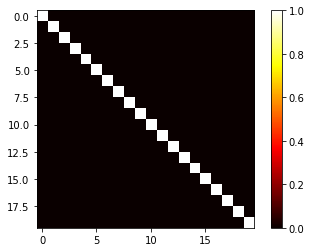

In [20]:
I_t=np.identity(20)
plt.imshow(I_t, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

# Generate the causal graph. 

1. Derive the parent node vector with length $T=[t_1,t_2,\cdots,t_T]$.
2. In the vector, let $t_i=0$ denotes that node $i$ has no parent, i.e. the node follows the prior distribution.
3. Let $t_i=j$ denote that node $i$'s parent is node $j$.

### Examples of causal graph and their visualizations

Example 1:

$$p(1)=0,p(2i)=2i-1,\enspace \forall i>0$$

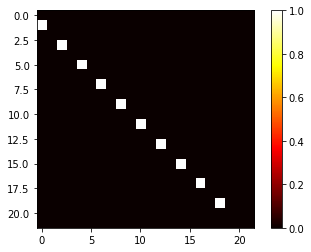

In [21]:
p=np.zeros((22,22))
for i in range(1,20):
    if (i+1)%2==0:
        p[i,i-1]=1

plt.imshow(p, cmap='hot')  # 'hot' is a popular colormap for heatmaps
plt.colorbar()  # Show color scale

### Generate Triansition matrix

The prior $P_\pi$ is choosen so that each row of $\pi$ is sampled i.i.d. from the Dirichlet distribution with parameter $\alpha$, i.e. $\pi(\cdot|s)\sim Dir(\alpha\cdot 1_S)$, for varying values of $\alpha$.

In [22]:
Transition_matrix=np.zeros((10,10))
for i in range(1,11):
    one_s=np.ones(10)
    alpha=np.random.dirichlet(i*one_s)
    Transition_matrix[i-1]=alpha

# check the sum of each row is 1
print(np.sum(Transition_matrix,axis=1))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


### Calculate the stationary distribution

In [23]:
# Calculate the left eigenvectors and eigenvalues
eigenvalues, left_eigenvectors = np.linalg.eig(Transition_matrix.T)

# Find the index of the eigenvalue closest to 1
index = np.argmin(np.abs(eigenvalues - 1))

# Extract the corresponding left eigenvector and normalize it
stationary_distribution = np.real(left_eigenvectors[:, index])
stationary_distribution /= stationary_distribution.sum()

# print("Stationary Distribution:\n", stationary_distribution)

# Check the validity of the stationary distribution
print("Check the validity of the stationary distribution:\n", sum(np.abs(stationary_distribution @ Transition_matrix-stationary_distribution)))

Check the validity of the stationary distribution:
 3.608224830031759e-16


### Generate random sequence with causal structure

There are 20 nodes and each nodes has 10 potential status

We need to generate the status of each node sequentially

1. When the node has no parent, its status is determined by the stationary distribution
2. When the node $i$ has parent $j$, its status is determined by $\pi(\cdot|s_{p(i)})=\pi(\cdot|s_j)$

In [28]:
#Parent vector where 0 represents no parent
Parent_vec=np.array([0,1,0,3,0,5,0,7,0,9,0,11,0,13,0,15,0,17,0,0,20])

# print(T[3])

#Generate iter random sequence with causal structure

iter=100000
Status=np.empty((iter,T+1))

for j in range(iter):

    #i is the index of the node
    for i in range(T-1):
        #If the node has no parent, the status of the node is generated from the stationary distribution
        if Parent_vec[i]==0:
            Status[j,i]=np.random.choice(range(S),1,p=stationary_distribution)
        
        else:
            #The parent of node i is Parent_vec[i]
            #The status of parent node is Status[j,Parent_vec[i]-1]
            #The conditional probability of the status of node i given its parent node Parent_vec[i] is Transition_matrix[Status[Parent_vec[i]-1]]
            Status[j,i]=np.random.choice(range(S),1,p=Transition_matrix[int(Status[j,Parent_vec[i]-1])])

    #The status of the node T is generated from the uniform distribution    
    Status[j,T-1]=np.random.choice(range(S),1)

    #The status of the node T+1 is the child of the node T
    Status[j,T]=np.random.choice(range(S),1,p=Transition_matrix[int(Status[j,T-1])])


In [29]:
Status=Status.astype(int)

In [30]:
Status.shape

(100000, 21)

In [32]:
#Store the generated data

np.savetxt("Status_2024_04_30.txt", Status, fmt='%d')  # '%d' for integer format

In [31]:
#Status of the last node
# print(Status[:,-1])

Remember that 

$$\tilde{X}^T=\begin{bmatrix}
    e_{s_1}& e_{s_2}&\cdots&e_{s_T}\\
    e_1&e_2&\cdots&e_T
\end{bmatrix}=\begin{bmatrix}
    \mathcal{E}_{s_{1:T}}\\
    \mathbb{I}_{T}
\end{bmatrix}$$

we have generate $\mathbb{I}_{T}$ before and we need to generate $\mathcal{E}_{s_{1:T}}$ for each sequence

In [9]:
I_10=np.identity(S)

X_tilde_T=np.empty((iter,S+T,T))

for i in range(iter):

    epsilon_1_T=np.zeros((S,T))

    #print(T)

    for k in range(T):
        epsilon_1_T[:,int(k)]=I_10[:,int(Status[i,int(k)])]

    #print(Status[0])

    X_tilde_T[i]=np.concatenate((epsilon_1_T,I_t),axis=0)


In [10]:
X_tilde_T.shape

(1000, 30, 20)

$$\begin{equation}
    \begin{split}
        h_T^{(1)^T}\tilde A^{(2)}h_i&=[\tilde x_T,attn(\tilde X;\tilde A^{(1)})_T]\begin{bmatrix}
            0_{S\times S} & 0_{S\times T} & A^{(2)} & 0_{S\times T}\\
            0_{T\times S} & 0_{T\times T} & 0_{T\times S} & 0_{T\times T}\\
            0_{S\times S} & 0_{S\times T} & 0_{S\times S} & 0_{S\times T}\\
            0_{T\times S} & 0_{T\times T} & 0_{T\times S} & 0_{T\times T}\\
        \end{bmatrix}\begin{bmatrix}
            \tilde x_i^T\\
            attn(\tilde X;\tilde A^{(1)})_i^T
        \end{bmatrix}\\
        &=\tilde x_T\begin{bmatrix}
            A^{(2)} & 0_{S\times T}\\
            0_{T\times S} & 0_{T\times T}
        \end{bmatrix}attn(\tilde X;\tilde A^{(1)})_i^T\\
        &=\textcolor{red}{[e_{s_T}^T,e_T^T]}\begin{bmatrix}
            A^{(2)} & 0_{S\times T}\\
            0_{T\times S} & 0_{T\times T}
        \end{bmatrix}attn(\tilde X;\tilde A^{(1)})_i^T\\
    \end{split}
\end{equation}$$

In [11]:
X_tilde_T[0,:,-1].reshape(1,-1)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]])

$$\begin{equation}
    \begin{split}
        h_T^{(1)^T}\tilde A^{(2)}h^{(1)}&=\textcolor{red}{[e_{s_T}^T,e_T^T]}\begin{bmatrix}
            A^{(2)} & 0_{S\times T}\\
            0_{T\times S} & 0_{T\times T}
        \end{bmatrix}attn(\tilde X;\tilde A^{(1)})^T\\
        &=\bar x_T^TA^{(2)}\bar X^T\mathcal{S}(MASK(A^{(1)}))^T
    \end{split}
\end{equation}$$

where $\textcolor{red}{\bar x_T^T}=e_{S_T}^T$, 

In [12]:
X_tilde_T[0,0:10,-1].reshape(1,-1)

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]])

$\bar X^T=[e_{S_1},e_{S_2},\cdots,e_{S_T}]$

In [13]:
X_tilde_T[0,0:10,:].shape

(10, 20)

Since Lemma 1 tell us that the output of Transformer can be simplified as 

$$
\widetilde{TF}_{\tilde\theta}(S_{1:T})=\bar X^T\mathcal{S}\bigl(\mathcal{S}(MASK(A^{(1)}))\bar XA^{(2)^T}\bar x_T\bigr)
$$

Notice that the out softmax is column wise and the inner softmax is row wise.

We can simplify the output of transformer as follow:

In [14]:
#define MASK function, where MASK(M_{ij})=M_{ij} if i>=j, otherwise -inf
def MASK(M):

    # Number of rows and columns
    num_rows, num_cols = M.shape

    # Create a new matrix for the masked results
    masked_matrix = np.full_like(M, fill_value=-np.inf, dtype=float)

    # Apply the condition i >= j
    for i in range(num_rows):
        for j in range(num_cols):
            if i >= j:
                masked_matrix[i, j] = M[i, j]

    return masked_matrix


In [15]:
import torch
from torch.autograd import Variable
from scipy.special import softmax

#store the output of transformer
TF=np.empty((S,iter))

delta=1e-3

#define TF+delta
TF_delta=np.empty((S,iter))

# A_1=Variable(torch.zeros(T, T), requires_grad=True)
# A_2=Variable(torch.zeros(S, S), requires_grad=True)

beta_0=1e-3

#initialize A_1 and A_2
A_1=np.zeros((T,T))
A_2=beta_0*np.identity(S)


#Compute outputs of transformer
for i in range(iter):
    X_T=X_tilde_T[i,0:10,:]
    x_T=X_tilde_T[i,0:10,-1]#.reshape(1,-1)
    TF[:,i]=X_T@ softmax(softmax(MASK(A_1),axis=1)@X_T.T@ A_2.T@x_T.T,axis=0)
    
    #normalize
    TF[:,i]=TF[:,i]/sum(TF[:,i])

    #store TF+delta
    TF_delta[:,i]=TF[:,i]+delta

$$
\widetilde{TF}_{\tilde\theta}(S_{1:T})=\bar X^T\mathcal{S}\bigl(\mathcal{S}(MASK(A^{(1)}))\bar XA^{(2)^T}\bar x_T\bigr)
$$
$$
\begin{equation*}
    \begin{split}
        attn(\tilde h^{(0)};\tilde{A}_1^{(1)})&=\mathcal{S}(MASK(\tilde h^{(0)}\tilde{A}_1^{(1)}\tilde h^{(0)T}))\tilde h^{(0)}\\
        &=S(MASK(\tilde X Z^{(0)T}A_1Z^{(0)}\tilde X^T))\tilde X\\
        &=S(MASK(h^{(0)} A_1h^{(0)T}))\tilde X
    \end{split}
\end{equation*}
$$

Since we need to constrain the trainable entries of $\widetilde{A}^{(1)}$ and $\widetilde{A}^{(2)}$ as

$$
\begin{equation*}
    \begin{split}
        \tilde A^{(1)}&=\begin{bmatrix}
            0_{S\times S} & 0_{S\times T}\\
            0_{T\times S} & A^{(1)}_1
        \end{bmatrix}\\
        % \tilde A_2^{(1)}&=\begin{bmatrix}
        %     0_{S\times S} & 0_{S\times T}\\
        %     0_{T\times S} & A^{(1)}_2
        % \end{bmatrix}\\
        \tilde A^{(2)}&=\begin{bmatrix}
            0_{S\times S} & 0_{S\times T} & A^{(2)} & 0_{S\times T}\\
            0_{T\times S} & 0_{T\times T} & 0_{T\times S} & 0_{T\times T}\\
            0_{S\times S} & 0_{S\times T} & 0_{S\times S} & 0_{S\times T}\\
            0_{T\times S} & 0_{T\times T} & 0_{T\times S} & 0_{T\times T}\\
        \end{bmatrix}\\
    \end{split}
\end{equation*}
$$

In [54]:
#S=10
# T=20

import torch

# Example of defining a matrix
total_matrix_A_1 = torch.randn(int(S+T), int(S+T), requires_grad=True)
total_matrix_A_2 = torch.randn(int(2*S+2*T), int(2*S+2*T), requires_grad=True)

# Define a mask where True means trainable
mask_A_1 = torch.tensor([[True if (i in range(S,int(S+T))  and  j in range(int(S),int(S+T))) else False for j in range(int(S+T))] for i in range(int(S+T))])
mask_A_2 = torch.tensor([[True if (i in range(0,S)  and  j in range(int(S+T),int(2*S+T))) else False for j in range(int(2*S+2*T))] for i in range(int(2*S+2*T))])

# Hook to apply the mask to the gradients
def apply_mask_1(grad):
    return grad * mask_A_1.type_as(grad)

def apply_mask_2(grad):
    return grad * mask_A_2.type_as(grad)

# Attach the hook
total_matrix_A_1.register_hook(apply_mask_1)

total_matrix_A_2.register_hook(apply_mask_2)



# # Example usage in a dummy forward pass
# output_2 = total_matrix_A_2.sum()
# output_2.backward()


# # Set print options
# torch.set_printoptions(threshold=10_000)
# # Check gradients
# print(total_matrix_A_2.grad)



# output_1 = total_matrix_A_1.sum()
# output_1.backward()
# print(total_matrix_A_1.grad[10:])


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])
tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
        [0., 0., 0., 0., 0., 

In [ ]:
import torch.nn as nn
import torch.optim as optim

for i in range(iter):
    X_T=X_tilde_T[i,0:10,:]
    x_T=X_tilde_T[i,0:10,-1]#.reshape(1,-1)
    
    h_0=X_T@EP

    score=torch.matmul(torch.matmul(h_0,A_1),h_0.T)

    TF[:,i]=X_T@ softmax(softmax(MASK(A_1),axis=1)@X_T.T@ A_2.T@x_T.T,axis=0)

$$
\begin{equation*}
    \begin{split}
        L(\theta)&=-\mathbb{E}_{\pi,S_{1:T}}\bigl[\sum_{s'\in [S]}\textcolor{red}{\pi(s'|s_T)}\log (f_\theta(s_{1:T})_{s'}+\epsilon)\bigr]\\
        % &=-\frac{1}{S}\mathbb{E}_{\pi,X}\bigl[\sum_{s,s'\in [S]}\pi(s'|s)\log (f_\theta(X;s)_{s'}+\epsilon)\bigr]
    \end{split}
\end{equation*}
$$

Since we already got $s_T$ for each random sequences *Status[:,-1]*, we can generate the conditional probability $\pi(\cdot|s_T)$

In [56]:
pi_given_ST=np.empty((S,iter))

for i in range(iter):
    pi_given_ST[:,i]=Transition_matrix[int(Status[i,-1])]

# print(pi_given_ST.shape)

#Store the target values
np.savetxt("Target_2024_04_30.txt", pi_given_ST, fmt='%f')  # '%d' for integer format

Then we can calculate the loss:

In [17]:
loss=np.empty(iter)
for i in range(iter):
    loss[i]=-np.dot(pi_given_ST[:,i],np.log(TF_delta[:,i]))

Loss=sum(loss)/iter
print(Loss)

2.819071921028783


# Use GD to train the model